In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

# 1. Load the Dataset
try:
    try:
        df = pd.read_csv('data/2025_Sterling_Financial_Dataset_clean.csv')
    except FileNotFoundError:
        df = pd.read_csv('2025_Sterling_Financial_Dataset_clean.csv')
    print("Dataset loaded successfully.")
    print("Columns found:", df.columns.tolist())
except FileNotFoundError:
    print("Error: File not found. Please upload '2025_Sterling_Financial_Dataset_clean.csv'")

# 2. Define X (Features) and y (Target)
target = 'default_history'

# Columns to drop (ID, Date, and raw Text are not useful for KNN)
# Kept 'sentiment' so that can drop the raw 'customer_feedback'
cols_to_drop = [target, 'customer_id', 'date', 'customer_feedback']

# Only drop columns that actually exist to avoid KeyError
existing_drop_cols = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df[target]

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Dataset loaded successfully.
Columns found: ['date', 'customer_id', 'location', 'business_sector', 'age', 'income', 'credit_score', 'savings_ratio', 'loan_amount', 'debt_to_income', 'credit_utilization', 'payment_punctuality', 'customer_feedback', 'default_history', 'sentiment', 'risk_category', 'customer_segment', 'feedback_topic']
Training shape: (1200, 14)
Testing shape: (300, 14)


# Preprocessing Pipeline

In [2]:
from imblearn.under_sampling import RandomUnderSampler

# 1. Identify which columns are numbers vs text
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 2. Define the Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Create the Main Pipeline
knn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),  # Balanced the classes by removing some '0's
    ('knn', KNeighborsClassifier())
])

print("Pipeline created successfully.")

Pipeline created successfully.


# Hyperparameter Tuning

In [3]:
# 1. Define the options to test
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# 2. Run the Search
print("Starting Grid Search...")
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1', n_jobs=None)
grid_search.fit(X_train, y_train)

# 3. Store the best model
best_model = grid_search.best_estimator_

print(f"Search Complete!")
print(f"Best k (neighbors): {grid_search.best_params_['knn__n_neighbors']}")

Starting Grid Search...
Search Complete!
Best k (neighbors): 15


# Evaluation Metrics (KNN)

KNN Model Results (Best Model)
Accuracy:  0.7767
Precision (Default): 0.1231
Recall (Default):    0.4444
F1-Score (Default):  0.1928
ROC-AUC Score:       0.7401


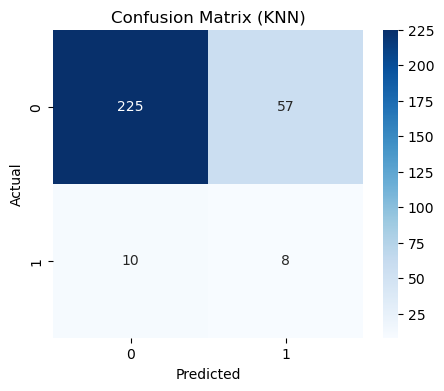

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Generate Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# 2. Calculate Scores
report = classification_report(y_test, y_pred, output_dict=True)
roc_score = roc_auc_score(y_test, y_prob)

# 3. Print Results
print("KNN Model Results (Best Model)")
print(f"Accuracy:  {report['accuracy']:.4f}")
print(f"Precision (Default): {report['1']['precision']:.4f}")
print(f"Recall (Default):    {report['1']['recall']:.4f}")
print(f"F1-Score (Default):  {report['1']['f1-score']:.4f}")
print(f"ROC-AUC Score:       {roc_score:.4f}")

# 4. Visualize Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (KNN)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()